# The Analysis of Spatial Data

The spatial data has been extracted from the dataset. The extraction scripts can be found in this [repo](https://github.com/xziyue/MCCNN-Playground).

In [2]:
# configure python path
import sys
import os
sys.path.append(os.path.abspath('..'))

# configure matplotlib
import matplotlib
matplotlib.rcParams['figure.dpi']= 250
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%config InlineBackend.figure_format = 'jpeg'

from IPython.display import HTML, display, Markdown
from tabulate import tabulate


# read data
import pickle
import numpy as np
from source.rel_path import rootDir

with open(os.path.join(rootDir, 'data', 'train_merged.pickle'), 'rb') as inFile:
    xs, ys, ids = pickle.load(inFile)
    
atoms = ['A', 'C', 'e', 'HD', 'OA']

## Spatial data after extraction

The shape of data points after extraction is (358, 15, 15, 15, 5). That is to say, there are 358 samples each with five $15 \times 15 \times 15$ grids.

In [3]:
print('the shape of xs:', xs.shape)

the shape of xs: (358, 15, 15, 15, 5)


## An unbalanced dataset
There are more negative samples compared to positive ones.

In [4]:
# show label distribution
num0s = np.count_nonzero(ys == 0)
num1s = np.count_nonzero(ys == 1)

labelDistTable = [
    ['Negative', 'Positive', 'Total'],
    [repr(num0s), repr(num1s), repr(xs.shape[0])]
]

display(Markdown('Label counts of the dataset:'))
display(HTML(tabulate(labelDistTable, colalign=['center']*3, tablefmt='html')))

Label counts of the dataset:

Negative,Positive,Total
259,99,358


## Standardize the dataset
When we inspect the statistics of each channel, it can be seen that the edge values differ greatly from each other. To compress the amplitude of each channel, each one of them is mapped to $[0, 1]$ with some specific transformations.

In [5]:
from scipy.stats import describe

channelStats = []
for ind in range(xs.shape[4]):
    channelStats.append(describe(np.take(xs, ind, axis=4).flat))

channelStatTable = [['channel index', 'min value', 'max value', 'mean', 'variance']]
for i in range(len(channelStats)):
    stat = channelStats[i]
    row = [repr(i + 1), repr(stat.minmax[0]), repr(stat.minmax[1]), 
           '{:.4f}'.format(stat.mean), '{:.4e}'.format(stat.variance)]
    channelStatTable.append(row)

display(Markdown('Before standardization:'))
display(HTML(tabulate(channelStatTable, colalign=['center']*5, tablefmt='html')))

Before standardization:

channel index,min value,max value,mean,variance
1,-0.939,400147.219,15005.3438,1.3411e+09
2,-1.056,400147.156,15005.2802,1.3411e+09
3,-47.955,45.892,0.5181,5.5090e+00
4,-1.105,200555.438,3810.1098,2.9298e+08
5,-1.965,400009.562,10484.3017,8.6604e+08


In [6]:
# functions to standardize the dataset

def get_standardized_channel(_channel, ind):
    channel = _channel.copy()
    channel -= channelStats[ind].minmax[0]
    channel += 1.0
    channel = np.log(channel)
    channel /= channel.max()
    return channel

def get_standardized_xs(_xs):
    xs = _xs.copy()
    for ind in range(xs.shape[4]):
        theIndex = tuple([slice(None)] * 4 + [ind])
        # special treatment for the e channel
        if ind == 2:
            stat = channelStats[ind]
            xs[theIndex] -= stat.minmax[0]
            xs[theIndex] /= (stat.minmax[1] - stat.minmax[0])
        else:
            xs[theIndex] = get_standardized_channel(xs[theIndex], ind)
    return xs

newXs = get_standardized_xs(xs)

newChannelStats = []
for ind in range(xs.shape[4]):
    newChannelStats.append(describe(np.take(newXs, ind, axis=4).flat))

newChannelStatTable = [['channel index', 'min value', 'max value', 'mean', 'variance']]
for i in range(len(newChannelStats)):
    stat = newChannelStats[i]
    row = [repr(i + 1), repr(stat.minmax[0]), repr(stat.minmax[1]), 
           '{:.4f}'.format(stat.mean), '{:.4e}'.format(stat.variance)]
    newChannelStatTable.append(row)

display(Markdown('After standardization:'))
display(HTML(tabulate(newChannelStatTable, colalign=['center']*5, tablefmt='html')))

After standardization:

channel index,min value,max value,mean,variance
1,0.0,1.0,0.3762,8.6785e-02
2,0.0,1.0,0.3772,8.6166e-02
3,0.0,1.0,0.5165,6.2550e-04
4,0.0,1.0,0.2038,5.7005e-02
5,0.0,1.0,0.3305,7.3888e-02


## Visualize grids
It would be great to show the grids extracted from the dataset and visually compare their differences.

In [7]:
# generate colormaps for each channel

cmapBase = cm.get_cmap('jet')
channelCmaps = []
for i in range(newXs.shape[4]):
    stat = newChannelStats[i]
    norm = matplotlib.colors.Normalize(vmin=stat.minmax[0], vmax=stat.minmax[1])
    colorFunc = lambda val : cmapBase(norm(val))
    channelCmaps.append(colorFunc)
    
def draw_new_sample(ind, drawThreshold=0.3):
    sample = newXs[ind, ...]
    fig = plt.figure(figsize=(12, 3))
    
    fig.suptitle(ids[ind])
    
    ii, jj = np.meshgrid(np.arange(newXs.shape[1]), np.arange(newXs.shape[2]), indexing='ij')
    
    for chId in range(newXs.shape[4]):
        ax = fig.add_subplot(1, newXs.shape[4], chId + 1, projection='3d')
        ax.set_title(atoms[chId])
        for zId in range(newXs.shape[3]):
            xy = sample[:, :, zId, chId]
            drawRegion = xy > drawThreshold
            drawXy = xy[drawRegion]
            colors = channelCmaps[chId](drawXy.flat)
            ax.scatter(ii[drawRegion], jj[drawRegion], marker='o', zs=zId, c=colors, s=10)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_zticks([])
    
    plt.show()

Negative samples:

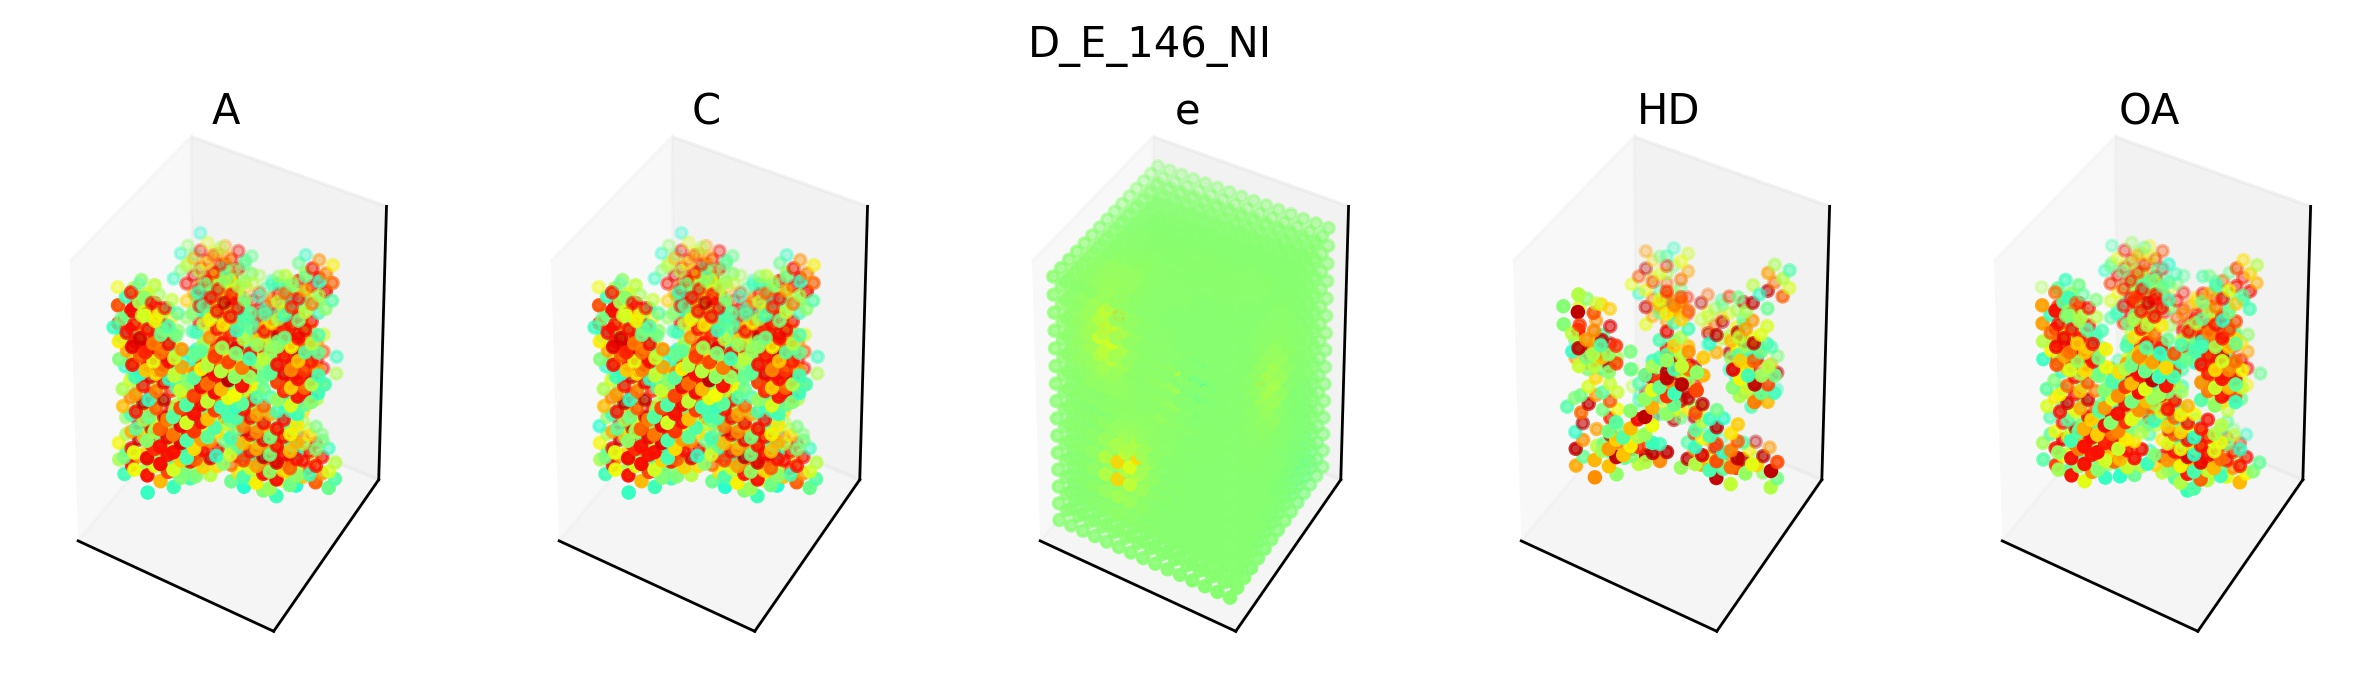

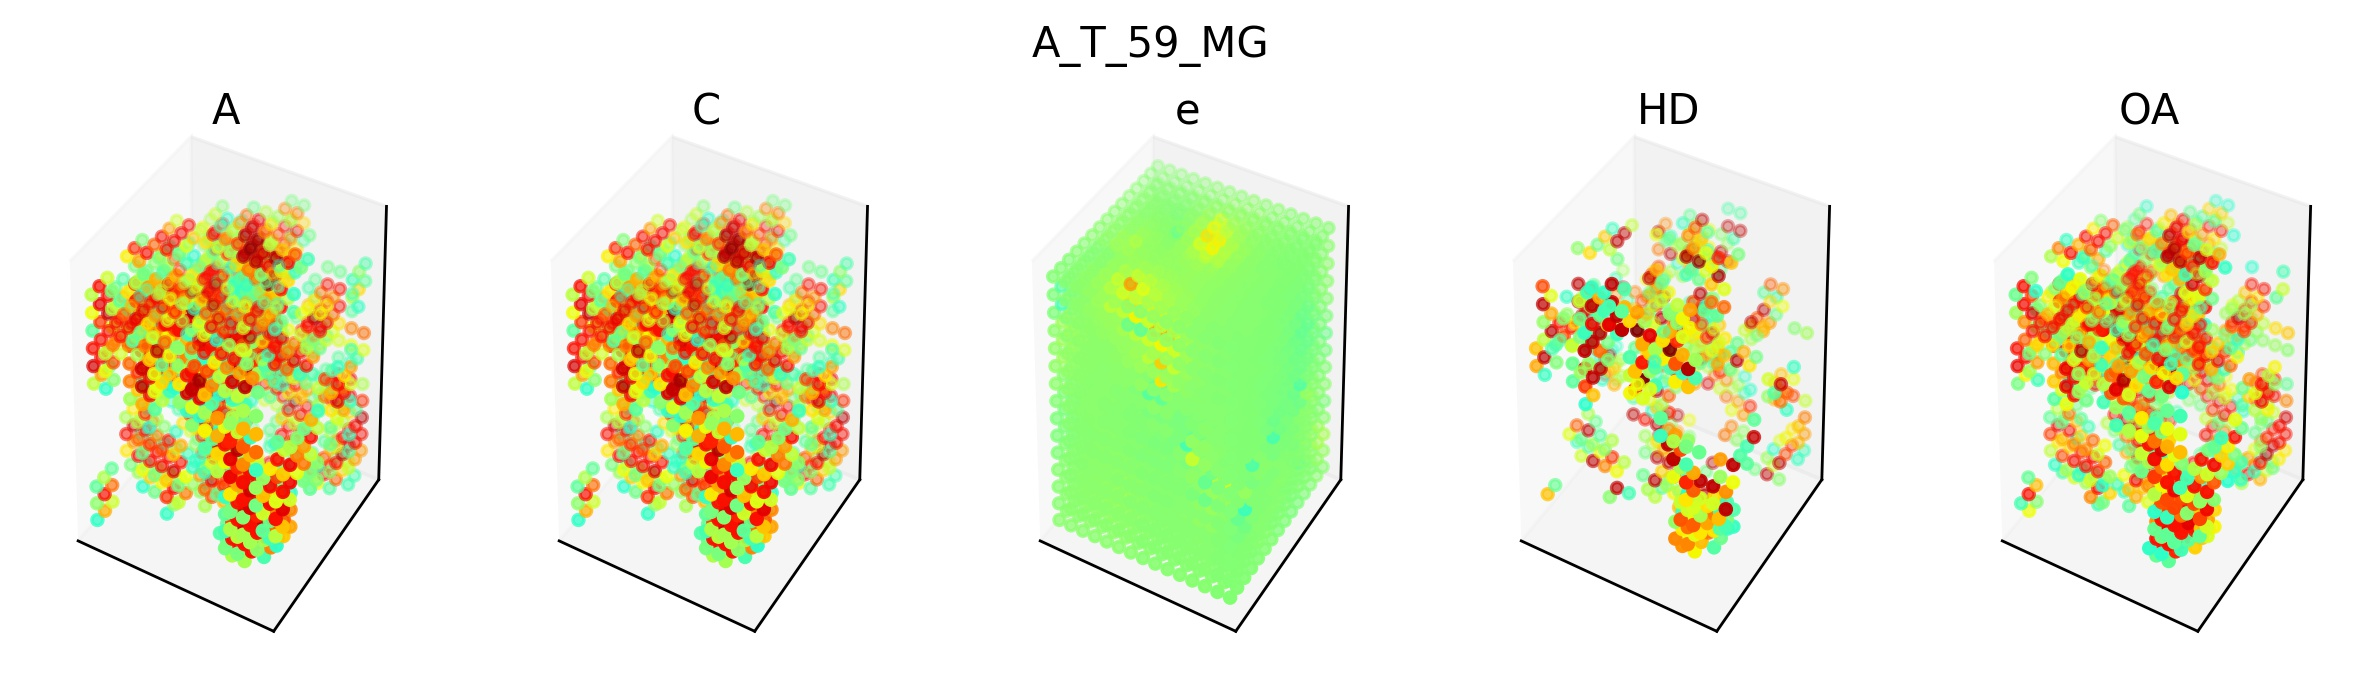

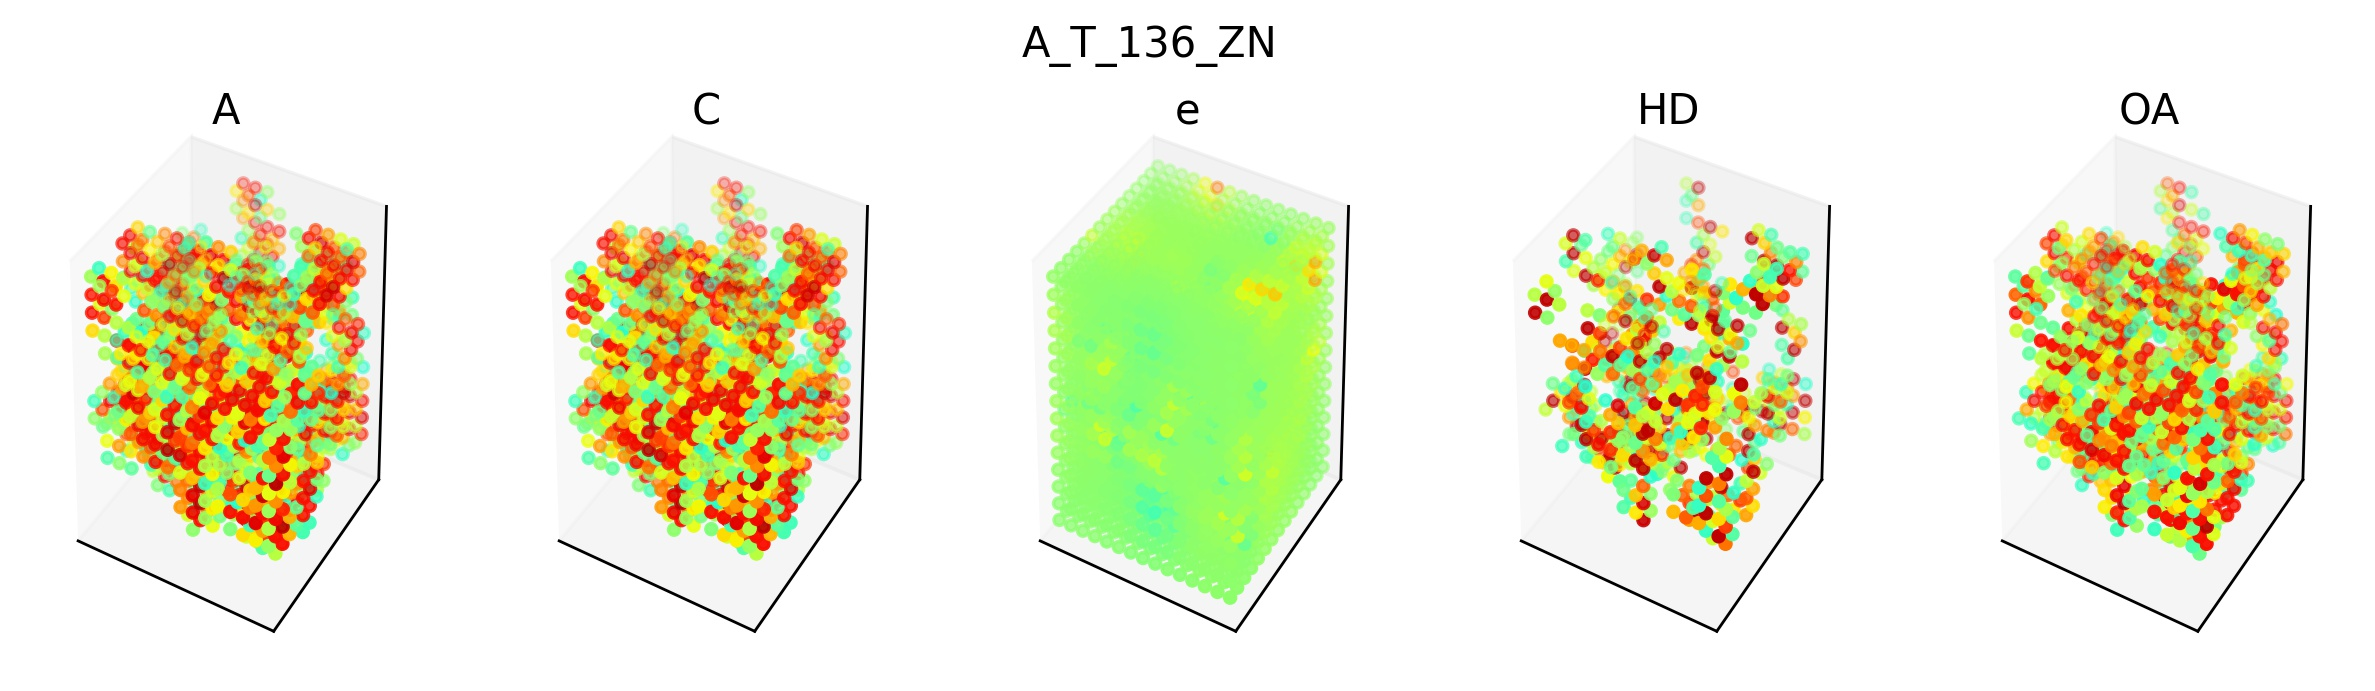

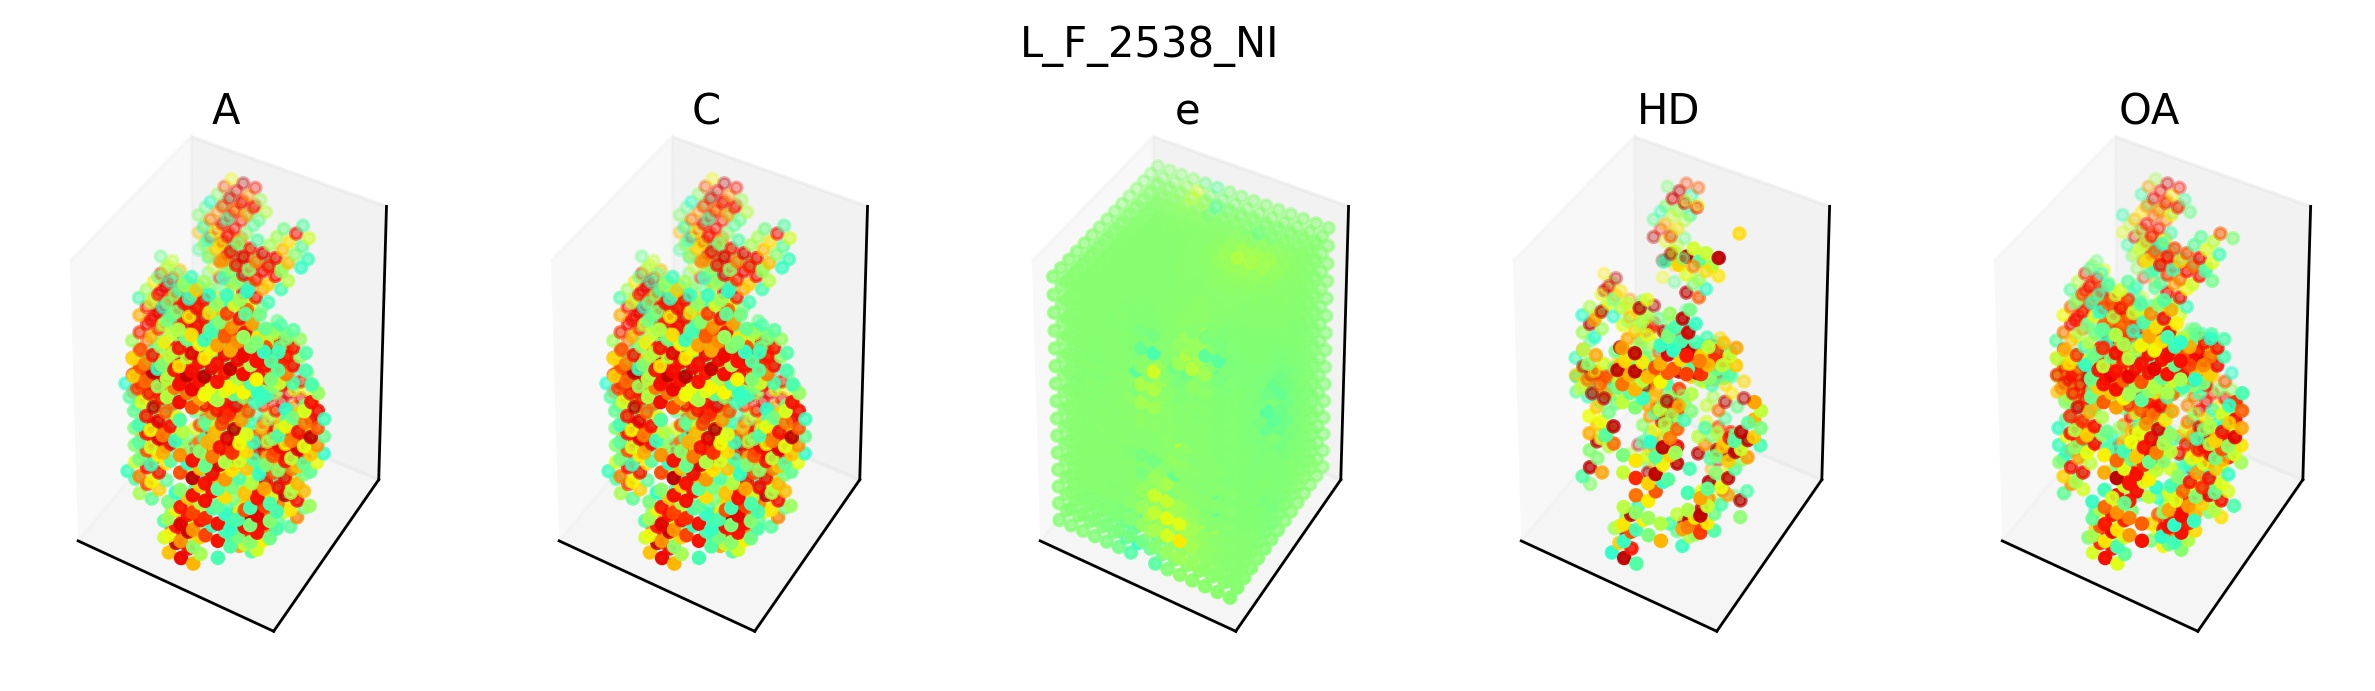

In [8]:
# draw different groups of samples
samples0 = np.where(ys == 0)[0]
samples1 = np.where(ys == 1)[0]

display(Markdown('Negative samples:'))
for i in range(4):
    draw_new_sample(samples0[i], 0.4)

Positive samples:

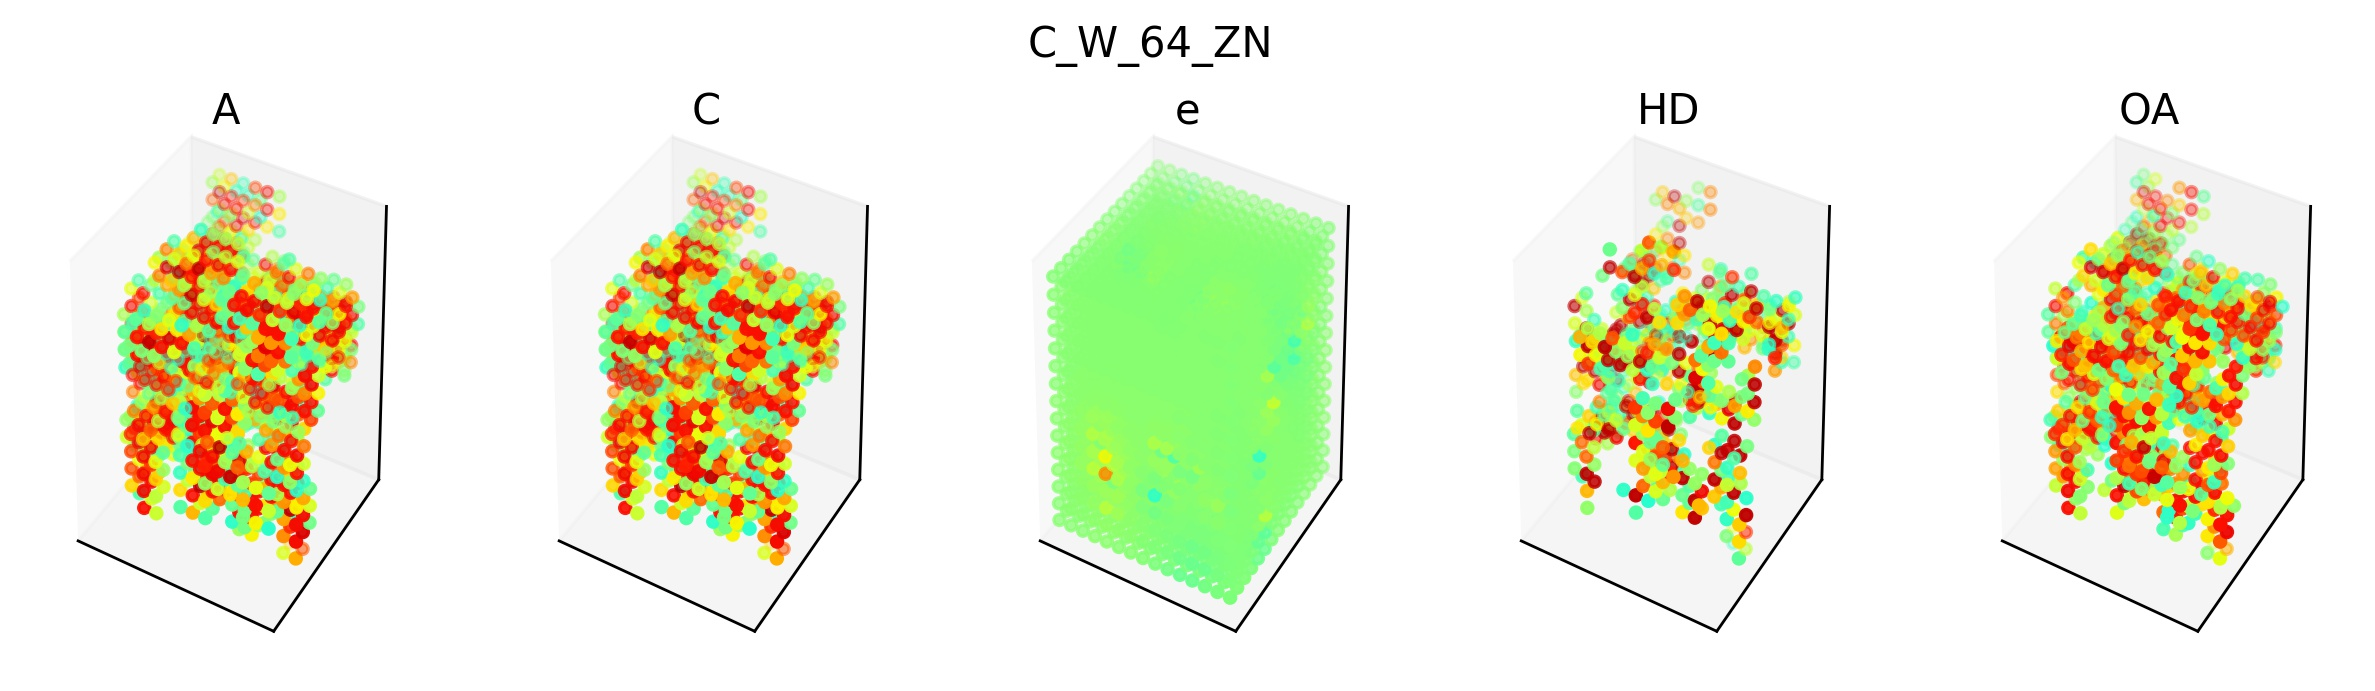

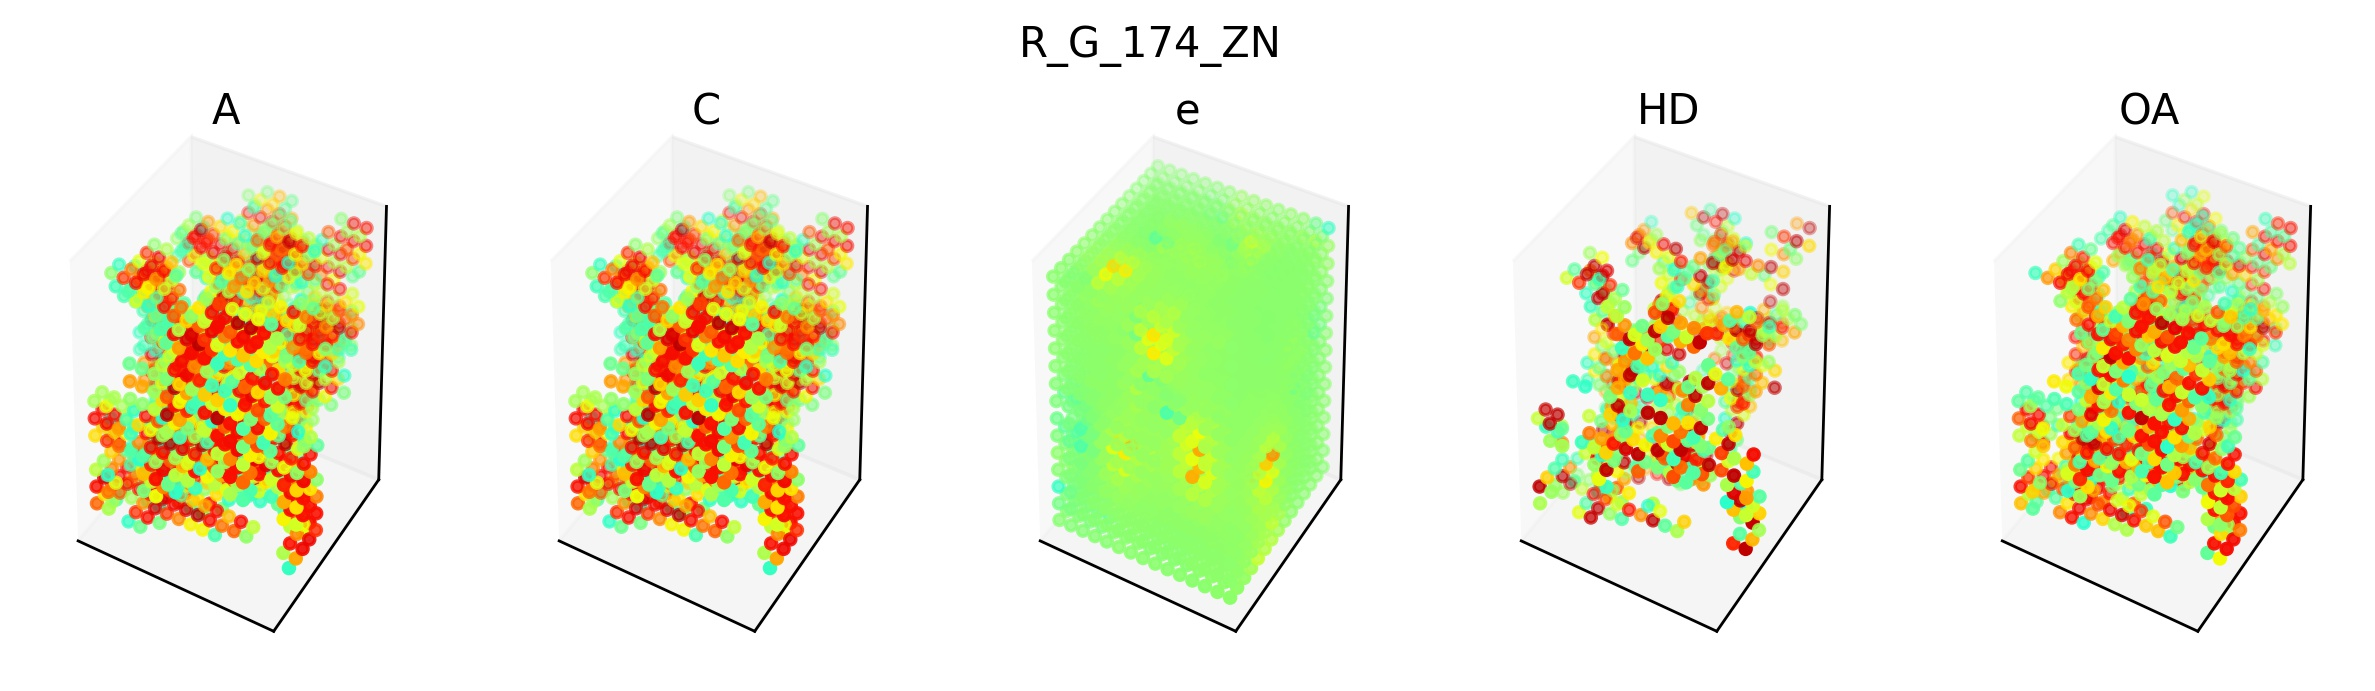

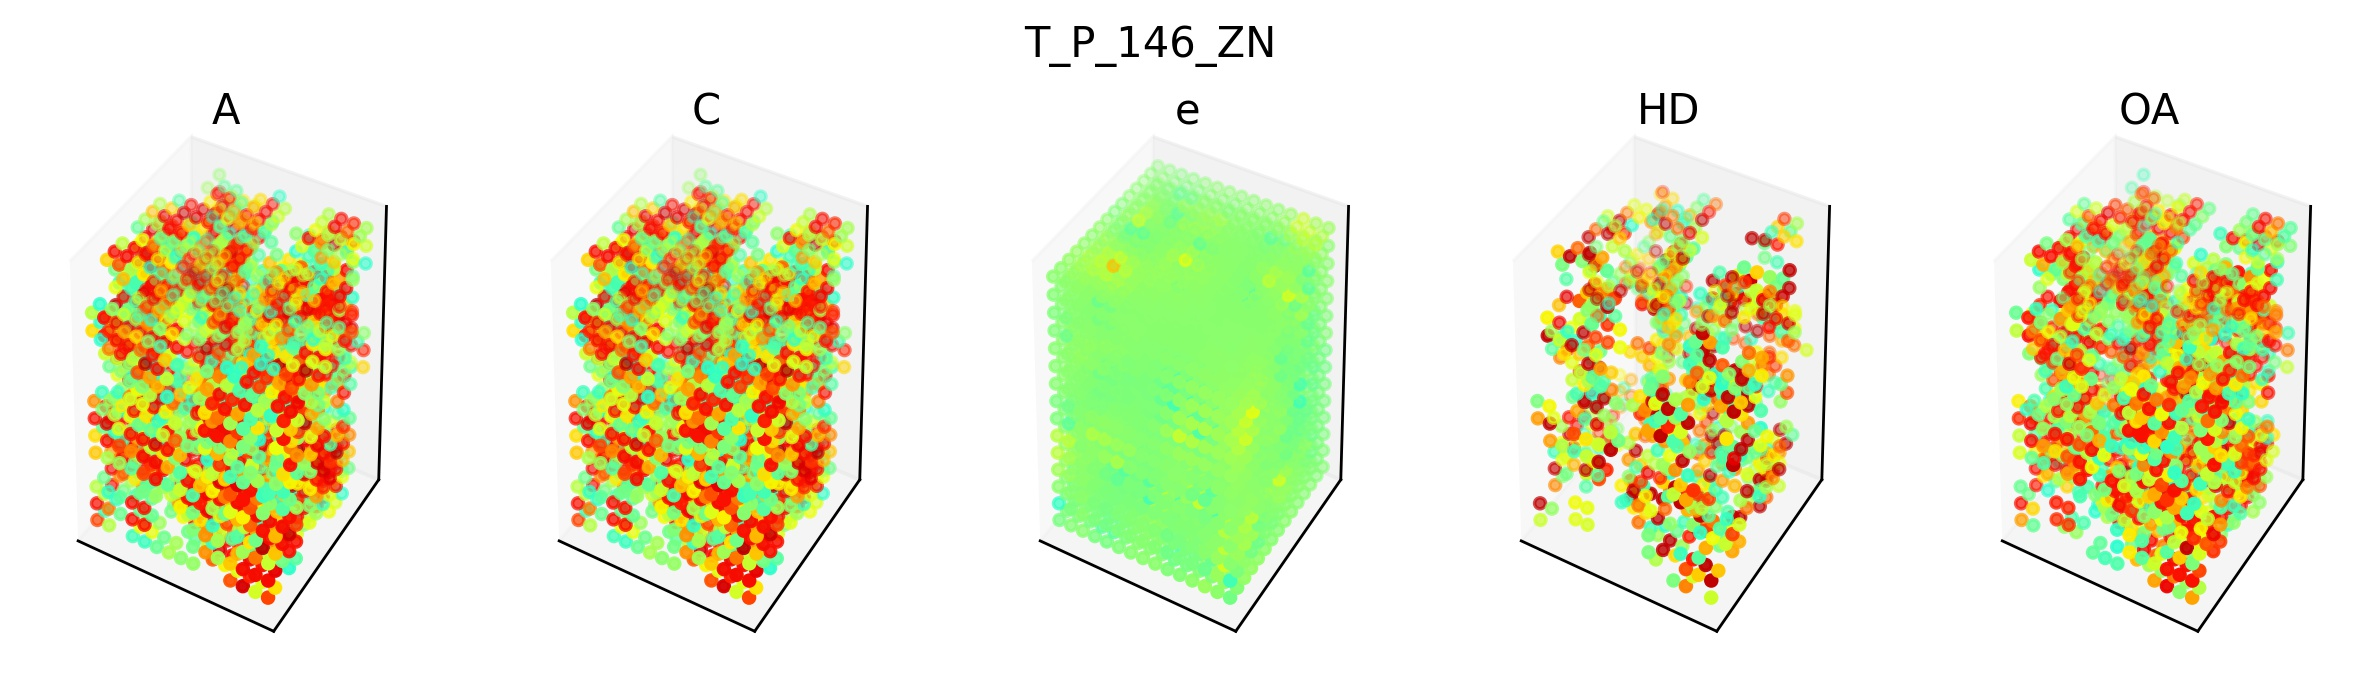

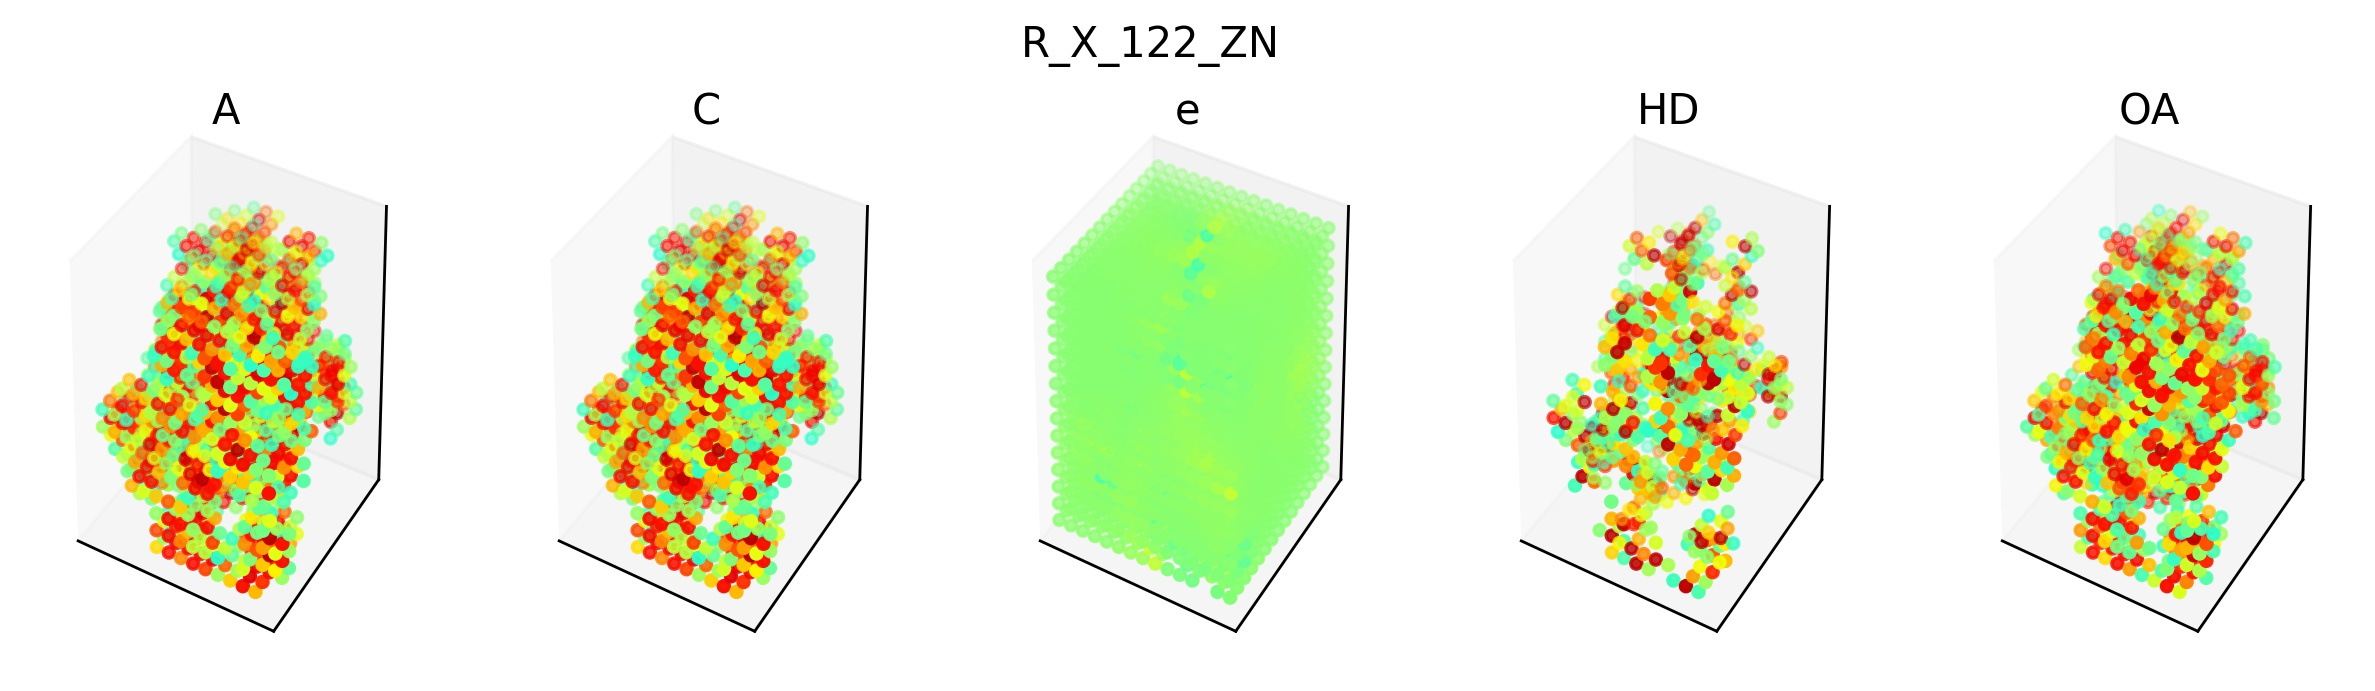

In [9]:
display(Markdown('Positive samples:'))
for i in range(4):
    draw_new_sample(samples1[i], 0.4)

## Experiment with simple methods

Trying out simple ML methods on spatial data

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import auc, roc_curve

kfold = StratifiedKFold(n_splits=5)

newXsSvmFull = newXs.reshape((newXs.shape[0], -1))

svmFullAucs = []
# test training on all channels
for train_idx, test_idx in kfold.split(newXsSvmFull, ys):
    x_train, y_train = newXsSvmFull[train_idx], ys[train_idx]
    x_test, y_test = newXsSvmFull[test_idx], ys[test_idx]
    svm = SVC(C=6.0, gamma='auto')
    svm.fit(x_train, y_train)
    fpr, tpr, thr = roc_curve(y_test, svm.predict(x_test))
    aucScore = auc(fpr, tpr)
    svmFullAucs.append(aucScore)

In [11]:
print('average AUC of SVM on all channels:', np.mean(svmFullAucs))

average AUC of SVM on all channels: 0.6457720092085417


In [12]:
svmChannelAucs = []
for chId in range(newXs.shape[4]):
    aucs = []
    newXsSvm = np.take(newXs, chId, axis=4).reshape((newXs.shape[0], -1))
    for train_idx, test_idx in kfold.split(newXsSvm, ys):
        x_train, y_train = newXsSvm[train_idx], ys[train_idx]
        x_test, y_test = newXsSvm[test_idx], ys[test_idx]
        svm = SVC(C=6.0, gamma='auto')
        svm.fit(x_train, y_train)
        fpr, tpr, thr = roc_curve(y_test, svm.predict(x_test))
        aucScore = auc(fpr, tpr)
        aucs.append(aucScore)
    svmChannelAucs.append(aucs)
svmChannelAucs = np.asarray(svmChannelAucs)

In [13]:
print('average AUC of SVM on each channel:')
print(np.mean(svmChannelAucs, axis=1))

average AUC of SVM on each channel:
[0.66077201 0.66077201 0.5        0.64881122 0.65381122]
